In [1]:
from keras.layers import LSTM
from keras.models import Sequential, load_model

from timeseries_ml_utils.data import *
from timeseries_ml_utils.statistics import *
from timeseries_ml_utils.encoders import *

import matplotlib.pyplot as plt

# encoders and decoders
linreg = RegressionLine(16)

# fetch data
#data = DataFetcher(["GLD.US"], limit=350)  # 550
data = DataFetcher(["GLD.US"])

print(data.fetch_data().tail())
print(len(data.get_dataframe()))


Using TensorFlow backend.


            GLD.US.Open  GLD.US.High  GLD.US.Low  GLD.US.Close  GLD.US.Volume
Date                                                                         
2018-12-13       117.54       117.62      117.26        117.53        4131770
2018-12-14       116.63       117.30      116.58        117.06        7501660
2018-12-17       117.37       118.03      117.35        117.87        8455007
2018-12-18       117.85       118.20      117.81        118.15        7542875
2018-12-19       118.24       118.96      117.40        117.43       13827509
2256


In [2]:
def regression_encode_decode(y, ref, encode):
    if encode:
        x = np.arange(0, len(y))
        y = normalize(y, ref, True)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        return np.array([intercept + slope * i for i in range(len(y))])
    else:
        return normalize(y, ref, False)


In [3]:
model_data = DataGenerator(data.get_dataframe(), 
                           {"^trigonometric": identity, 
                            "(Open|High|Low|Close)$": normalize}, 
                           {"GLD.US.Close$": regression_encode_decode},
                           aggregation_window_size=16, batch_size=10, 
                           training_percentage=0.8, 
                           model_path="/tmp/keras-regression-line-price-1")
print(model_data.get_df_columns())
print("feature shape:", model_data.batch_feature_shape)
print("labels shape:", model_data.batch_label_shape)
print("train/test data:", len(model_data), len(model_data.as_test_data_generator()))
print("max batch size:", model_data.get_max_batch_size())
model_data.features, model_data.labels


['GLD.US.Open', 'GLD.US.High', 'GLD.US.Low', 'GLD.US.Close', 'GLD.US.Volume', 'GLD.US.Open_variance', 'GLD.US.High_variance', 'GLD.US.Low_variance', 'GLD.US.Close_variance', 'GLD.US.Volume_variance', 'trigonometric_time.cos_dow', 'trigonometric_time.sin_dow', 'trigonometric_time.cos_woy', 'trigonometric_time.sin_woy', 'trigonometric_time.cos_doy', 'trigonometric_time.sin_doy', 'trigonometric_time.sin_yer', 'trigonometric_time.cos_yer', 'trigonometric_time.sin_dec', 'trigonometric_time.cos_dec']
feature shape: (10, 260, 224)
labels shape: (10, 16)
train/test data: 1565 392
max batch size: 1


([('GLD.US.Open', <function timeseries_ml_utils.encoders.normalize>),
  ('GLD.US.High', <function timeseries_ml_utils.encoders.normalize>),
  ('GLD.US.Low', <function timeseries_ml_utils.encoders.normalize>),
  ('GLD.US.Close', <function timeseries_ml_utils.encoders.normalize>),
  ('trigonometric_time.cos_dow',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.sin_dow',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.cos_woy',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.sin_woy',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.cos_doy',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.sin_doy',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.sin_yer',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.cos_yer',
   <function timeseries_ml_utils.encoders.identity>),
  ('trigonometric_time.s

In [4]:

model = Sequential(name="LSTM-Model-1")
model.add(LSTM(model_data.batch_label_shape[-1],
               name="LSTM-Layer-1",
               batch_input_shape=model_data.batch_feature_shape,
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=True))

model.add(LSTM(model_data.batch_label_shape[-1] * 2,
               name="LSTM-Layer-2",
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=True))

model.add(LSTM(model_data.batch_label_shape[-1],
               name="LSTM-Layer-3",
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=model_data.return_sequences))

model.compile("Adam", loss="mse", metrics=['mae', 'acc'])

train_args = {"epochs": 1,
              "use_multiprocessing": True,
              "workers": 4,
              "shuffle": False,
              "verbose": 1}

fit = model_data.fit(model, train_args, frequency=10, relative_accuracy_function=r_square)
print("done")

Epoch 1/1
1565/1565 [==============================] - 637s 407ms/step - loss: 7.3469e-04 - mean_absolute_error: 0.0204 - acc: 0.1574 - val_loss: 3.5062e-04 - val_mean_absolute_error: 0.0148 - val_acc: 0.0000e+00
done


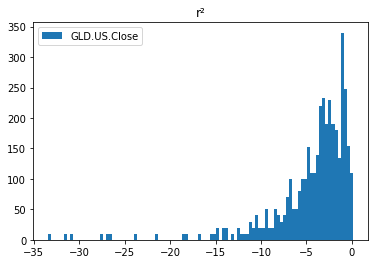

In [23]:
back_test = fit.back_test_history
prediction = fit.predict(-1)
back_test.plot_hist()

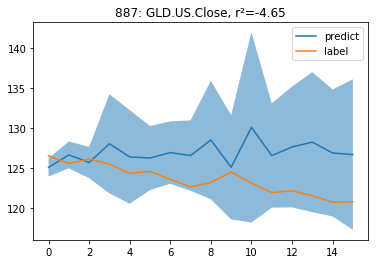

In [24]:
back_test.plot_random_sample()

2018-12-20 00:00:00 2019-01-04 00:00:00
            GLD.US.Close  GLD.US.Close_lower  GLD.US.Close_upper
2019-01-04    117.101463           100.36258          133.840347


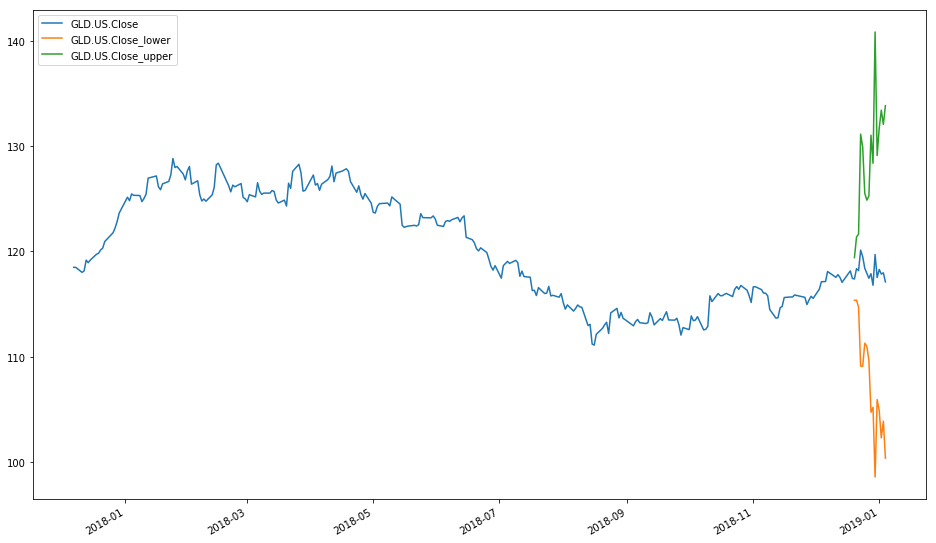

In [29]:
print(prediction.index[-16], prediction.index[-1])
print(prediction[-1:])
prediction.plot(figsize=[16,10])

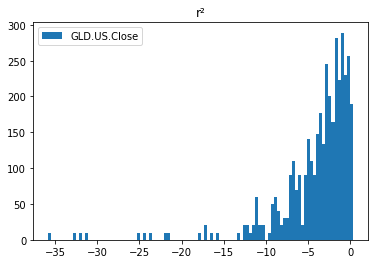

In [3]:
#restored = PredictiveDataGenerator("/home/kic/Documents/keras/keras-regression-line-price-1", data.get_dataframe())
restored = PredictiveDataGenerator("/tmp/keras-regression-line-price-1", data.get_dataframe())
back_test = restored.back_test_history
back_test.plot_hist(bins=100)

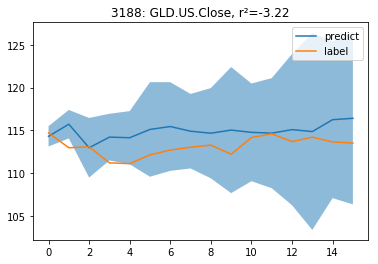

In [4]:
restored.back_test_history.plot_random_sample()

In [5]:
restored.predict(-1)

AttributeError: type object 'datetime.datetime' has no attribute 'timedelta'